## Analysis of IRIS data

In this tutorial you will learn to load and work with IRIS data in Python using [IRISPy](https://iris.lmsal.com/itn45/IRIS-LMSALpy_chapter4.html) and other standard packages. IRISPy is still under heavy development, so some of the options used here may change in later versions. There is another tutorial in ITN 41, [A low-level guide to IRIS with Python](http://iris.lmsal.com/itn41/index.html), where similar tasks are done using only lower-level libraries. This tutorial can be seen as a high-level version of ITN 41, one that is easier to use.

This tutorial is given as a jupyter notebook. You will need to run the code in the cells in a sequential manner to make it work. Press shift+enter on a cell to run it. This version of the tutorial is the **solution**, all cells have been filled up with the correct answer. Please do not run this during the lectures, instead run the notebook `IRIS_hands-on.ipynb` in the same directory.

In the first code cell we have a bunch of imports and configuration settings.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.visualization import quantity_support
from astropy.time import Time

from IPython.display import set_matplotlib_formats

from irispy.io import read_iris_sji_level2_fits as read_sji
from irispy.io import read_iris_spectrograph_level2_fits as read_sp

# Set up some default matplotlib options
quantity_support()
set_matplotlib_formats('svg')
plt.rc('image', origin='lower')
plt.rc('xtick', direction='out')
plt.rc('figure', figsize=(6, 5)) # Larger figure sizes
plt.rc('font', size=12)

# Silence warnings
import warnings
warnings.filterwarnings("ignore")

### 1. Working with IRIS spectrograph files

Now let us start by reading a spectrograph file. We are going to use the option `memmap=True` to avoid loading the whole file into memory. We also use `uncertainty=False` to avoid calculating the uncertainties, which takes even more time and memory. Note that when `memmap=True`, the data values are read from the FITS file directly without the scaling to `Float32`,  the data values are no longer in DN, but in scaled integer units that start at −2$^{16}$/2.

In [2]:
sp = read_sp('iris_l2_20180102_153155_3610108077_raster_t000_r00000.fits',
             uncertainty=False, memmap=True)

In [3]:
sp

NDCollection
------------
Cube keys: ('C II 1336', 'O I 1356', 'Si IV 1394', 'Si IV 1403', '2832', '2814', 'Mg II k 2796')
Number of Cubes: 7
Aligned dimensions: [<Quantity 1. pix> <Quantity 320. pix> <Quantity 548. pix>]
Aligned world physical axis types: ('meta.obs.sequence', 'custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')

In [4]:
sp.keys()

dict_keys(['C II 1336', 'O I 1356', 'Si IV 1394', 'Si IV 1403', '2832', '2814', 'Mg II k 2796'])

In [5]:
mg = sp['Mg II k 2796'][0]

In [6]:
mg[0]

SpectrogramCube
---------------
Time Period: 2018-01-02T15:31:55.870
Instrument axes: None
Pixel dimensions: [548 380] pix
Longitude range: [-0.10703502 -0.10646485] deg
Latitude range: [0.05452208 0.10507361] deg
Spectral range: [2.79065478e-07 2.80995346e-07] m
Data unit: DN_IRIS_NUV

In this case our sequence is only one 320-step raster, so we chose `mg` to be the zeroth index. As seen above, is a 3D cube with 2 dimensions of space and one of wavelength. We can make plots of cuts along this cube:

<WCSAxesSubplot:xlabel='em.wl [m]', ylabel='custom:pos.helioprojective.lat [deg]'>

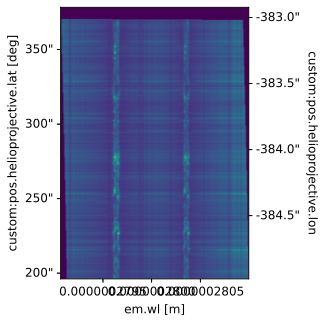

In [7]:
mg[0].plot()

<AxesSubplot:xlabel='em.wl [m]', ylabel='Data [DN_IRIS_NUV]'>

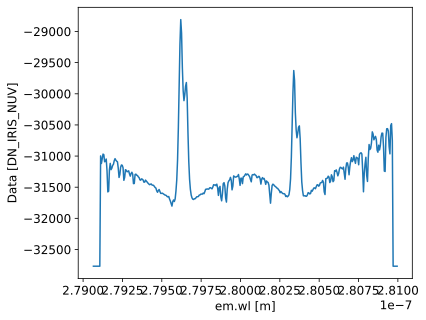

In [8]:
mg[120, 200].plot()

The default plots take the units and labels from the FITS WCS information, and often do not come in the most useful units (e.g. wavelengths in metres). Note the negative scale for the data because we are using `memmap=True` (otherwise, these would be data numbers). We can read the wavelengths of the Mg window by calling `axis_world_coords` for `wl` (wavelength), and redo the plot with a better scale:

In [9]:
mg_wave = mg.axis_world_coords('wl')
mg_wave.to('m')

<Quantity [2.79065478e-07, 2.79070570e-07, 2.79075662e-07, 2.79080754e-07,
           2.79085846e-07, 2.79090938e-07, 2.79096030e-07, 2.79101122e-07,
           2.79106214e-07, 2.79111306e-07, 2.79116398e-07, 2.79121490e-07,
           2.79126582e-07, 2.79131674e-07, 2.79136766e-07, 2.79141858e-07,
           2.79146950e-07, 2.79152042e-07, 2.79157134e-07, 2.79162226e-07,
           2.79167318e-07, 2.79172410e-07, 2.79177502e-07, 2.79182594e-07,
           2.79187686e-07, 2.79192778e-07, 2.79197870e-07, 2.79202962e-07,
           2.79208054e-07, 2.79213146e-07, 2.79218238e-07, 2.79223330e-07,
           2.79228422e-07, 2.79233514e-07, 2.79238606e-07, 2.79243698e-07,
           2.79248790e-07, 2.79253882e-07, 2.79258974e-07, 2.79264066e-07,
           2.79269158e-07, 2.79274250e-07, 2.79279342e-07, 2.79284434e-07,
           2.79289526e-07, 2.79294618e-07, 2.79299710e-07, 2.79304802e-07,
           2.79309894e-07, 2.79314986e-07, 2.79320078e-07, 2.79325170e-07,
           2.79330262e-07

(-32000.0, -30200.0)

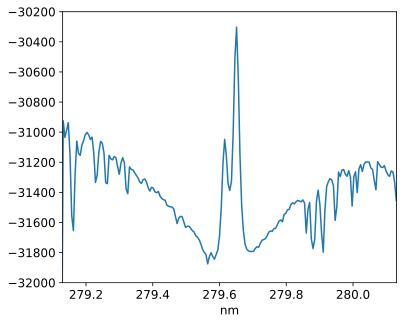

In [10]:
fig, ax = plt.subplots()
plt.plot(mg_wave.to('nm'), mg[10, 10].data)
ax.set_xlim(279.13 * u.nm, 280.13 * u.nm)
ax.set_ylim(-32000, -30200)

We can also improve on the default spectrogram plot by adjusting some options:

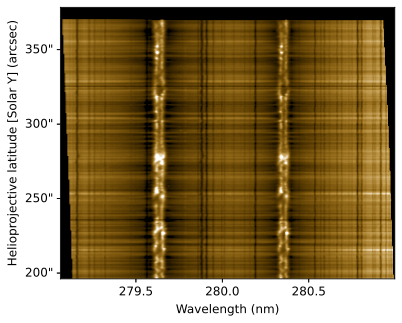

In [11]:
mg[0].plot(vmin=-31800, vmax=-29500, aspect='auto', cmap='irissjiNUV')
ax = plt.gca()
ax.coords[0].set_major_formatter('x.x') 
ax.coords[0].set_format_unit(u.nm)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Helioprojective latitude [Solar Y] (arcsec)')
ax.coords[2].set_ticks([]*u.degree)  # Remove longitude ticks

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
What is the wavelength position that corresponds to Mg II k core (279.63 nm)?
</div>

In [12]:
tmp = mg.world_to_pixel(0 * u.arcsec, 0 * u.arcsec, 279.63 * u.nm)
mg_index = int(np.round(tmp[-1].value))
mg_index

111

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
Plot spectroheliogram for Mg II k core wavelength.

</div>

<WCSAxesSubplot:xlabel='custom:pos.helioprojective.lat [deg]', ylabel='custom:pos.helioprojective.lon [deg]'>

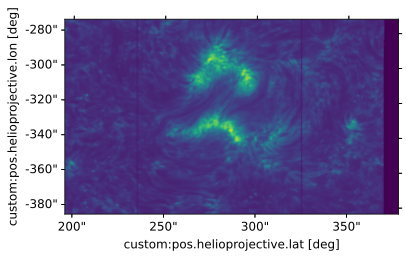

In [13]:
mg[:, :, mg_index].plot()

Using the default `.plot()` method will show a cut with the position of the axes in the same order as they are saved in the FITS file. This means that latitude (solar Y) will be in the x axis and longitude (solar X) in the y axis. To properly plot them, we need to manually redo the plot with a transposed version of the data, which involves a few more lines of code:

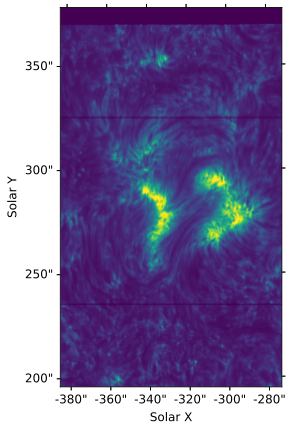

In [14]:
fig = plt.figure(figsize=(6, 7))
ax = plt.subplot(projection=mg.wcs.dropaxis(0), slices=('y', 'x'))
ax.imshow(mg.data[:, :, mg_index].T, vmin=-31800, vmax=-22500)
ax.set_xlabel("Solar X")
ax.set_ylabel("Solar Y")

Imagine there's a really cool feature at (-338", 275"), how can you plot the spectrum at that location? You can use `world_to_pixel` to convert from solar coordinates to array indices and make the plot:

In [15]:
tmp = mg.world_to_pixel(-338 * u.arcsec, 275 * u.arcsec, 279.63 * u.nm)
coords = [int(np.round(a.value)) for a in tmp[:2]]
coords

[133, 238]

<AxesSubplot:xlabel='em.wl [m]', ylabel='Data [DN_IRIS_NUV]'>

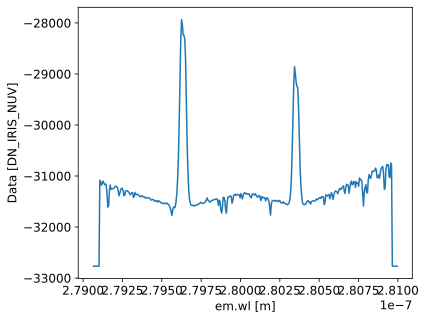

In [16]:
mg[coords[0], coords[1]].plot()

Now, you may also be interested in knowing the time that was this observation taken. There is some information in `.meta`:

In [17]:
mg.meta

{'SAT_ROT': <Quantity 0.00023047 deg>,
 'DATE_OBS': <Time object: scale='utc' format='isot' value=2018-01-02T15:31:55.870>,
 'DATE_END': <Time object: scale='utc' format='isot' value=2018-01-02T16:20:52.740>,
 'HLZ': False,
 'SAA': False,
 'DSUN_OBS': <Quantity 1.47094e+11 m>,
 'IAECEVFL': 'NO',
 'IAECFLAG': 'NO',
 'IAECFLFL': 'NO',
 'KEYWDDOC': 'http://www.lmsal.com/iris_science/irisfitskeywords.pdf',
 'detector type': 'NUV',
 'spectral window': 'Mg II k 2796',
 'OBSID': '3610108077',
 'OBS_DESC': 'Very large dense 320-step raster 105.3x175 320s   Deep x 8 Spatial x',
 'STARTOBS': <Time object: scale='utc' format='isot' value=2018-01-02T15:31:55.700>,
 'ENDOBS': <Time object: scale='utc' format='isot' value=2018-01-02T16:21:01.960>}

But this is mostly about the observation in general. Times of individual scans are saved in `.extra_coords['time']['value']`. This will give an array with the same length as the number of scans:

In [18]:
mg.extra_coords['time']['value'][coords[0]]

<Time object: scale='utc' format='isot' value=2018-01-02T15:52:20.430>

In [19]:
mg.extra_coords['time']['value'][coords[0]].isot

'2018-01-02T15:52:20.430'

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
Exercise: plot a spectroheliogram for the C II 133.566 nm line. Use `vmin=-31950` and `vmax=-31750`.
   
</div>

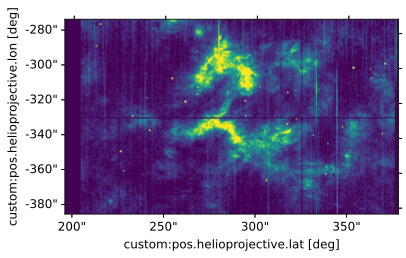

In [20]:
cii = sp['C II 1336'][0]
cii_wave = cii.axis_world_coords('wl')
cii_index = int(np.abs(cii_wave - 133.566 * u.nm).argmin())
cii[:, :, cii_index].plot(vmin=-31950, vmax=-31750);

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
**Optional** exercise: plot a spectroheliogram for the Si IV 139.38 nm line. Use `vmin=-31950` and `vmax=-31700`.
    
</div>

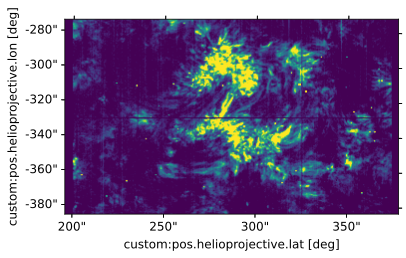

In [21]:
si = sp['Si IV 1394'][0]
si_wave = si.axis_world_coords('wl')
si_index = int(np.abs(si_wave - 139.38 * u.nm).argmin())
si[:, :, si_index].plot(vmin=-31950, vmax=-31700);

### 2. Working with IRIS Slit-Jaw Image files

To work with IRIS SJI files, we use the function we renamed `read_sji`. Note that in this case the file is small, so we don't need to use `memmap=True`. Note also that we can read the `.gz` compressed file directly:

In [22]:
sji = read_sji("iris_l2_20180102_153155_3610108077_SJI_1400_t000.fits.gz")

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [23]:
sji.meta

{'TELESCOP': 'IRIS',
 'INSTRUME': 'SJI',
 'DATA_LEV': 2.0,
 'TWAVE1': 1400.0,
 'OBSID': '3610108077',
 'STARTOBS': <Time object: scale='utc' format='isot' value=2018-01-02T15:31:55.700>,
 'ENDOBS': <Time object: scale='utc' format='isot' value=2018-01-02T16:21:01.960>,
 'SAT_ROT': <Quantity 0.00022743 deg>,
 'NBFRAMES': 80,
 'OBS_DESC': 'Very large dense 320-step raster 105.3x175 320s   Deep x 8 Spatial x',
 'FOVX': <Quantity 281.132 arcsec>,
 'FOVY': <Quantity 182.32 arcsec>,
 'XCEN': <Quantity -329.321 arcsec>,
 'YCEN': <Quantity 286.652 arcsec>}

Can't remember what is OBSID 3610108077? IRISpy has an utility function that will print out some more information:

In [24]:
from irispy.obsid import ObsID

In [25]:
ObsID(sji.meta['OBSID'])

IRIS OBS ID 3610108077
----------------------
Description:       Very large dense 320-step raster 105.3x175 320s
SJI filters:                  C II   Si IV   Mg II h/k   Mg II w
SJI field of view:                                       175x175
Exposure time:                                               8.0 s
Binning:                               Spatial x 2, Spectral x 2
FUV binning:                              FUV binned same as NUV
SJI cadence:                                 SJI cadence default
Compression:                                Lossless compression
Linelist:                                         Large linelist

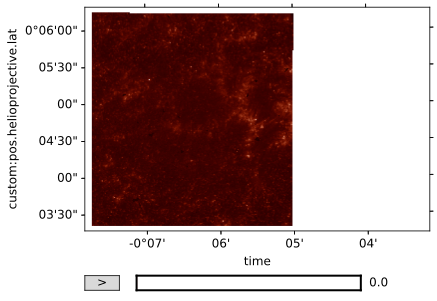

In [26]:
sji.plot()

<WCSAxesSubplot:xlabel='custom:pos.helioprojective.lon [deg]', ylabel='custom:pos.helioprojective.lat [deg]'>

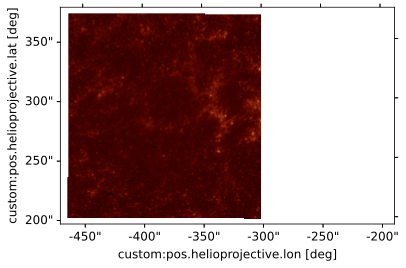

In [27]:
sji[0].plot()

Just as in the spectrograph case, we can pass some simple options to the plot function. Note that from SunPy we also get the IRIS colour maps!

<WCSAxesSubplot:xlabel='custom:pos.helioprojective.lon [deg]', ylabel='custom:pos.helioprojective.lat [deg]'>

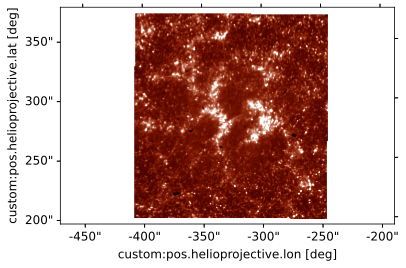

In [28]:
sji[40].plot(vmin=0, vmax=80)

Because the FITS files have the WCS coordinate information, we can use this to work in solar coordinates instead of pixels in the array. For example, let us cut the central part, from -375" to -275" in solar X and 250" to 325" in solar Y. We need to specify the bottom and top corners for the cut (note the coordinate order needs to match the FITS WCS header, and is inverse from the plotted image, so y comes first, x second).

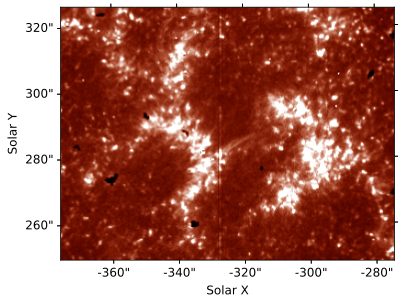

In [29]:
sji_cut = sji[40].crop_by_coords(lower_corner=(250 * u.arcsec, -375 * u.arcsec), 
                                 upper_corner=(325 * u.arcsec, -275 * u.arcsec))
sji_cut.plot(vmin=0, vmax=80)
plt.xlabel("Solar X")
plt.ylabel("Solar Y")

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

Print the time of the current observation (`sji_cut` object).
    
</div>

In [30]:
sji_cut.extra_coords['time']['value'].isot

'2018-01-02T15:56:56.420'

Now let's load a different SJI file.

In [31]:
del sji
sji = read_sji("iris_l2_20140919_051712_3860608353_SJI_2832_t000.fits.gz")

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


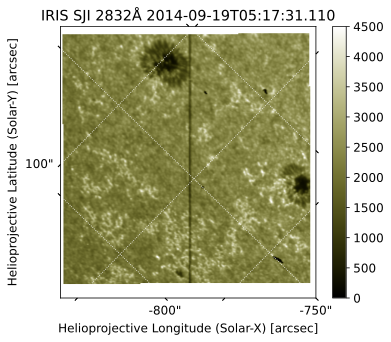

In [32]:
ax = plt.subplot(projection=sji.wcs.dropaxis(-1))
img = ax.imshow(sji[0].data, cmap='irissji2832', vmin=0, vmax=4500)
ax.grid(color='w', ls=':')
ax.set_xlabel("Helioprojective Longitude (Solar-X) [arcsec]")
ax.set_ylabel("Helioprojective Latitude (Solar-Y) [arcsec]")
ax.set_title("IRIS SJI %.0fÅ %s" % (sji.meta['TWAVE1'],
                                    sji.extra_coords['time']['value'][0]))
plt.colorbar(img, ax=ax);

This dataset has a peculiarity: the observation has a 45 degree roll. The image does not have a 45 degree rotation because plotting shows the data in the way they are written in the file, for efficiency. In the above, we added a coordinate grid to make this more clear.

Lets us now find the SJI observation where the time is closest to 06:00 on 2014-09-19. There are several ways of doing this. One is to use the time arrays in `extra_coords['time']['value']`:

In [33]:
time_sji = sji.extra_coords['time']['value']
time_target = Time('2014-09-19T06:00:00.0')
time_index = np.abs(time_sji - time_target).argmin()
time_sji[time_index]

<Time object: scale='utc' format='isot' value=2014-09-19T05:59:10.020>

### 3. Aligning IRIS SJI with AIA

Let us know assume we want to alight this IRIS observation with an AIA image. The fact that it is rolled 45 degrees makes it even more interesting, difficult to do manually, and will illustrate the power of working with WCS. In the current directory there is an AIA 170 nm image that was taken close to 06:00 on this same day. We will need to use SunPy to load this image. Let's also import a few more functions and modules:

In [34]:
import sunpy.map
from sunpy.instr.aia import aiaprep

from matplotlib.patches import Polygon
from astropy.coordinates import SkyCoord

And now let us plot a subset of the AIA image, close to the IRIS observation:

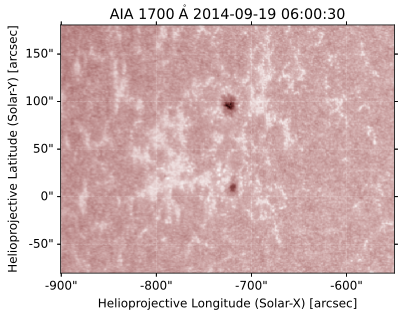

In [35]:
aia_file = 'aia_20140919_060030_1700_image_lev1.fits'
tmp = sunpy.map.Map(aia_file)
aia = aiaprep(tmp)  # to bring it up to level 1.5

# create a submap around the sunspots
top_right = SkyCoord(-550*u.arcsec, 180*u.arcsec, frame=aia.coordinate_frame)
bottom_left = SkyCoord(-900 * u.arcsec, -80. * u.arcsec, frame=aia.coordinate_frame)
aia_sub = aia.submap(top_right, bottom_left)
aia_sub.plot()

Now let's plot the IRIS field of view on the AIA image using the information from the WCS coordinates. We will use the `pixel_to_world` to convert from pixels to WCS coordinates, and then plot a polygon using the coordinates of the 4 corners of the IRIS image:

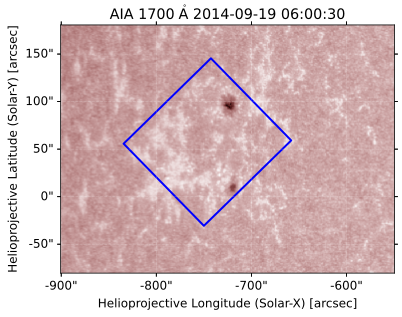

In [36]:
aia_sub.plot()
ax = plt.gca()
dims = sji.data.shape
_, ypts, xpts = sji.pixel_to_world(np.zeros(4) * u.pix, 
                                   [0, dims[1] - 1, dims[1] -1 , 0] * u.pix,
                                   [0, 0, dims[2] - 1, dims[2] - 1] * u.pix)
iris_points = np.array([xpts.value, ypts.value, ]).T
r = Polygon(iris_points, closed=True, edgecolor='b', facecolor='none', lw=2,
            transform=ax.get_transform('world'))
ax.add_patch(r)

So now we have the blue square showing the region of the IRIS observations. If we compare with the IRIS image above, this seems right: we capture both sunspots, and one of them is close to the edge. To work with both IRIS and AIA data, it helps if the image axes are aligned, and for this we need to rotate one of them. We can either rotate AIA to the IRIS frame, or vice-versa. Generally, it is easier to rotate AIA to IRIS because IRIS images are higher resolution and the files contain a sequence of images. Let's do that, again using the WCS coordinates of both objects. First, we rotate the AIA map using the inverse rotation of the IRIS frame:

In [37]:
aia_rot = aia.rotate(rmatrix=np.matrix(sji.wcs.wcs.pc[:-1, :-1]).I)

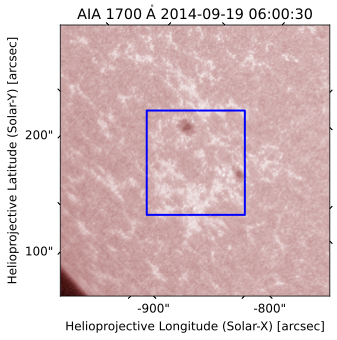

In [38]:
# Create submap on rotated image, with slightly smaller lower field of view
top_right = SkyCoord(-610*u.arcsec, 160*u.arcsec, frame=aia_rot.coordinate_frame)
bottom_left = SkyCoord(-880 * u.arcsec, -40. * u.arcsec, frame=aia_rot.coordinate_frame)
aia_rot_sub = aia_rot.submap(top_right, bottom_left)
aia_rot_sub.plot()
# add the same IRIS field-of-view:
ax = plt.gca()
r = Polygon(iris_points, closed=True, edgecolor='b', facecolor='none', lw=2,
            transform=ax.get_transform('world'))
ax.add_patch(r) 
plt.show()

If we want to show an AIA and IRIS image side by side, we can now crop the rotated AIA image to exactly the same size as the IRIS image:

In [39]:
top_right = SkyCoord(xpts[0], ypts[0], frame=aia_rot.coordinate_frame)
bottom_left = SkyCoord(xpts[-2], ypts[-2], frame=aia_rot.coordinate_frame)
aia_rot_sub = aia_rot.submap(top_right, bottom_left)

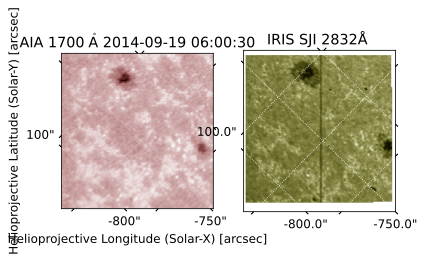

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection=aia_rot_sub)
aia_rot_sub.plot()

ax2 = fig.add_subplot(1,2,2, projection=sji.wcs.dropaxis(-1))
ax2.imshow(sji.data[40], cmap='irissji2832', vmin=0, vmax=4500)
ax2.coords[0].set_major_formatter('s.s')
ax2.coords[1].set_major_formatter('s.s')
ax2.set_title("IRIS SJI %.0fÅ " % (sji.meta['TWAVE1']))
ax2.grid(color='w', ls=':')
ax2.set_xlabel(' ')
ax2.set_ylabel(' ')